In [1]:
import numpy as np
import torch as th
th.use_deterministic_algorithms(True)
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSSVD
#custom multi-agent setup
import game_definition


In [2]:
#create a 1 step game
game = game_definition.StageGame(10,2,coupling_w=1,seed=123)
game.play([0 for i in range(game.n)])


tensor(0.6396, device='cuda:0')

In [3]:
#Import the algorithm
from algorithms import IPGA_stage_game

In [4]:
#test a few function to verify that everything was imported correctly
game = game_definition.StageGame(2,2,coupling_w=0.5,seed=231242351,device="cpu")
init_pol = th.rand(game.n,game.na,device=game.device,generator=game.gen)
init_pol=init_pol/init_pol.sum(-1)[...,None]
init_pol
end_pol = IPGA_stage_game(game,init_pol=init_pol)
polnp = np.argmax(end_pol.detach().cpu().numpy(),1)
print(f"converged to a nash: {game.is_nash(polnp)}                     ")

converged to a nash: True                     


In [6]:
def compute_2D_stage_game(game_seed,n_init_pol,coupling_w=0,separable_type="additive",aligned=True,lr=None):
    """Create a batch of random initial policies and compute IPG on them.

    Args:
        game_seed (int): Seed used to create the game
        n_init_pol (int): number of initial policies
        coupling_w (int, optional): w parameter of the game. Defaults to 0.
        separable_type (str, optional): Separability, either "multiplicative" or "additive". Defaults to "additive".
        aligned (bool, optional): Whether both the coupled and separable reward have the same maximum. Defaults to True.
        lr (float, optional): learning rate. Defaults to None. If none, 1/(n_a*(N-1)) will be used

    Returns:
        ndarray: The initial policies, shape = (n_init_pol, 2, 2)
        ndarray: The final policies, shape = (n_init_pol, 2, 2)
        ndarray: The reward obtained, shape = (n_init_pol)
    """
    n_pol_p = int(np.sqrt(n_init_pol))
    game = game_definition.StageGame(2,2,coupling_w=coupling_w,
                                     seed=game_seed,
                                     device="cuda",
                                     separable_type=separable_type,
                                     aligned=aligned,
                                     )
    rs_end = []
    pols_init = []
    pols_end = []
    for p1pol in np.linspace(0,1,n_pol_p):
        for p2pol in np.linspace(0,1,n_pol_p):
            init_pol = th.tensor([[p1pol,1-p1pol],[p2pol,1-p2pol]],device=game.device)
            pols_init.append(init_pol.cpu().numpy())
            end_pol = IPGA_stage_game(game,init_pol=init_pol,lr=lr)
            
            rs_end.append(game.solve_stoc_pol(end_pol).detach().cpu().numpy())
            pols_end.append(end_pol.detach().cpu().numpy())
    pol_ar = np.array(pols_init)
    pol_end_ar = np.array(pols_end)
    return pol_ar,pol_end_ar,np.array(rs_end)

In [7]:
game_definition.StageGame(2,2,coupling_w=1,seed=3,device="cuda",separable_type="additive").r

tensor([[1.0000, 0.0399],
        [0.0000, 0.4247]], device='cuda:0')

In [8]:
def plot_attraction_2D(init_pol,end_pol,r,title="Attaction bassins, 2 players 2 actions",figname=None):
    
    plt.scatter(init_pol[:,0,0],init_pol[:,1,0],cmap='turbo',vmin=0,vmax=1,c=r,alpha=0.1,s=0.1)
    """t_embed = embedding.transform(np.vstack([init_pol.reshape(init_pol.shape[0],-1),end_pol.reshape(end_pol.shape[0],-1)]))
    t_embed_init = t_embed[:init_pol.shape[0]]
    t_embed_end = t_embed[init_pol.shape[0]:]"""

    end_unique,idx = np.unique(end_pol,axis=0,return_index=True)
    end_points = plt.scatter(end_unique[:,0,0],end_unique[:,1,0],cmap='turbo',vmin=0,vmax=1,c=r[idx],marker="X",zorder=100,edgecolors='k')
    for i in range(init_pol.shape[0]):
        plt.plot(np.stack([init_pol,end_pol])[:,i,0,0],np.stack([init_pol,end_pol])[:,i,1,0],alpha=0.1,c=plt.cm.turbo(r[i]))
    plt.title(title)
    plt.gca().set_xlabel("P(P1 choses a1)")
    plt.gca().set_ylabel("P(P2 choses a1)")
    plt.gca().set_aspect('equal')
    cbar= plt.colorbar(end_points)
    cbar.set_label('Reward of the final policy')
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()
    

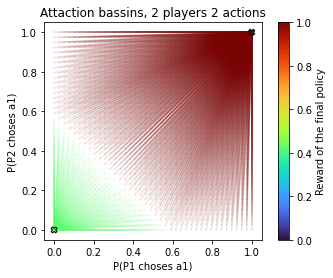

In [9]:
seed = 3
pol_init,pol_end,r = compute_2D_stage_game(seed,1600,coupling_w=1,aligned=True,separable_type="multiplicative")
plot_attraction_2D(pol_init,pol_end,r,figname=f"attraction_coupled_seed_{seed}")

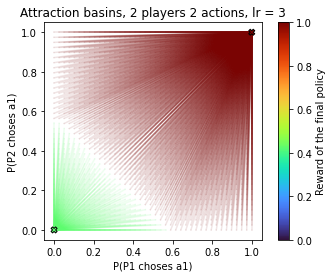

In [10]:
seed = 3
lr=3
pol_init,pol_end,r = compute_2D_stage_game(seed,1600,coupling_w=1,aligned=True,lr=lr)
plot_attraction_2D(pol_init,pol_end,r,title=f"Attraction basins, 2 players 2 actions, lr = {lr}",figname=f"attraction_coupled_a_seed_{seed}_lr_{lr}")

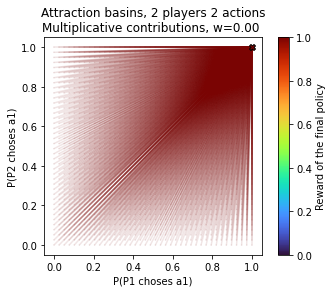

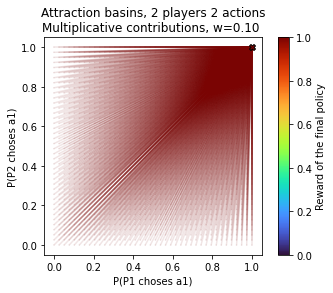

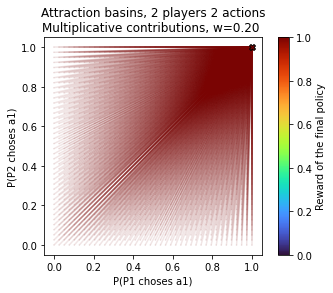

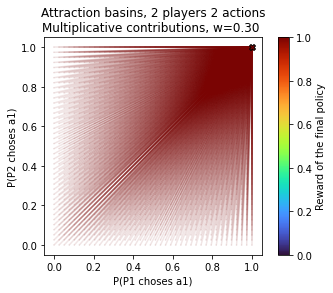

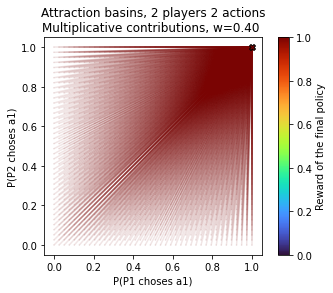

KeyboardInterrupt: 

In [11]:
seed = 3
for w in np.linspace(0,1,11):
    pol_init,pol_end,r = compute_2D_stage_game(seed,1600,coupling_w=w,aligned=True,separable_type="multiplicative")
    plot_attraction_2D(pol_init,pol_end,r,figname=f"attraction_coupled_m_seed_{seed}_w_{w:.2f}",title=f"Attraction basins, 2 players 2 actions\nMultiplicative contributions, w={w:.2f} ")


In [80]:
def get_ND_stage_game(n_players,n_actions,n_init_pols,game_seed=0,init_seed=0,aligned=True,separable_type="additive",coupling_w=1,lr=None,return_greedy = False):
    game = game_definition.StageGame(n_players,n_actions,coupling_w=coupling_w,seed=game_seed,device="cuda",aligned=aligned,separable_type=separable_type)
    th.manual_seed(init_seed)
    init_pols = th.rand(n_init_pols,n_players,n_actions,device=game.device)
    init_pols /= init_pols.sum(-1)[...,None]
    init_pol_ar = init_pols.cpu().numpy()
    end_pol = IPGA_stage_game(game,init_pol=init_pols,iter=500000,lr=lr)
    if len(end_pol.unique())!=2:
        print("Warning: The algorithm did not converge")
        if return_greedy:
            print(f"Returning greedy policy, maximum difference:{0.5 - th.min(th.abs(end_pol-0.5))}")
            end_pol_greedy, rs_end = game.solve_greedy_pol_batch(end_pol)
            rs_end = rs_end.detach().cpu().numpy()
            end_pol_ar = end_pol_greedy.detach().cpu().numpy()
        else:
            print(f"Returning intermediate policy, maximum difference:{0.5 - th.min(th.abs(end_pol-0.5))}")
            rs_end= game.solve_stoc_pol_batch(end_pol).detach().cpu().numpy()
            end_pol_ar = end_pol.detach().cpu().numpy()
    else:
        rs_end= game.solve_stoc_pol_batch(end_pol).detach().cpu().numpy()
        end_pol_ar = end_pol.detach().cpu().numpy()
    return init_pol_ar,end_pol_ar,rs_end

In [62]:
def plot_attraction(init_pol,end_pol,r,embedding=None,title="Embedding of the attaction bassins",figname=None):
    
    embedding = embedding or PLSSVD().fit(init_pol.reshape(init_pol.shape[0],-1),end_pol.reshape(end_pol.shape[0],-1))
    t_embed_init,t_embed_end = embedding.transform(init_pol.reshape(init_pol.shape[0],-1),end_pol.reshape(end_pol.shape[0],-1))
    plt.scatter(t_embed_init[:,0],t_embed_init[:,1],cmap='turbo',vmin=0,vmax=1,c=r,alpha=0.1,s=0.1)
    t_embed_end_unique,idx = np.unique(t_embed_end,axis=0,return_index=True)

    """t_embed = embedding.transform(np.vstack([init_pol.reshape(init_pol.shape[0],-1),end_pol.reshape(end_pol.shape[0],-1)]))
    t_embed_init = t_embed[:init_pol.shape[0]]
    t_embed_end = t_embed[init_pol.shape[0]:]"""

    t_embed_end_unique,idx = np.unique(t_embed_end,axis=0,return_index=True)
    end_points = plt.scatter(t_embed_end_unique[:,0],t_embed_end_unique[:,1],cmap='turbo',vmin=0,vmax=1,c=r[idx],marker="X",zorder=100,edgecolors='k')
    for i in range(t_embed_init.shape[0]):
        plt.plot(np.stack([t_embed_init,t_embed_end])[:,i,0],np.stack([t_embed_init,t_embed_end])[:,i,1],alpha=0.1,c=plt.cm.turbo(r[i]))
    plt.title(title)
    plt.gca().set_xlabel("Embedding dimension 1")
    plt.gca().set_ylabel("Embedding dimension 2")
    cbar = plt.colorbar(end_points)
    cbar.set_label('Reward of the final policy')
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()
    return embedding

In [66]:
n=10
na=2
for game_seed in range(2):
    init_pol,end_pol01,r01 = get_ND_stage_game(n,na,5000,coupling_w=1,game_seed=game_seed,lr=0.1)
    lr = 1/(na*(n-1))#smoothness of the game
    init_pol,end_pol1,r1 = get_ND_stage_game(n,na,5000,coupling_w=1,game_seed=game_seed,lr=lr)
    if (end_pol01==end_pol1).all():
        print(f"No learning rate influence between 0.1 and {lr} in {game_seed=}")
    else:
        print(f"Learning rate influence between 0.1 and {lr} in {game_seed=}")
        print(f"The learning rate of 0.1 improved the result by {np.mean(r01-r1)}")
        


KeyboardInterrupt: 

In [74]:
game_seeds = np.arange(10)
init_seed = 0
n_players = 5
n_actions = 2
n_init_pol = 1000
lr_l = 1/((n_players-1)*n_actions)*np.array([0.1,0.5,1,2,10,20])
w = 1

In [75]:
idx = 0
g = game_definition.StageGame(n_players,n_actions,coupling_w=w,seed=int(game_seeds[idx]),device="cuda",aligned=True,separable_type="additive")
g.r.sum()

tensor(15.8946, device='cuda:0')

In [76]:
((n_players-1)*n_actions)

8

In [77]:
r_lr = []
for lr in lr_l:
    print(f"currently processing {lr=:.4f}  ")
    r = []
    for seed in game_seeds:
        _,end_pol,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=int(seed),init_seed=init_seed,separable_type="multiplicative",lr=lr,return_greedy=True)
        r.append(r_s)
    r_lr.append(np.concatenate(r))

currently processing lr=0.0125  
currently processing lr=0.1250  
currently processing lr=0.2500  
currently processing lr=1.2500  
currently processing lr=2.5000  


In [78]:
def nash_quality_rel_vs_lr(lr_l,r_l,smooth_idx,mode='mean',figname=None):
    fig,ax = plt.subplots()
    dif = np.stack([r - r_l[smooth_idx] for r in r_l])
    if mode=='mean':
        mean = np.mean(dif,axis=1)
        var = np.std(dif,axis=1)
        ax.plot(lr_l,mean)
        ax.fill_between(lr_l,mean-var,mean+var,alpha = 0.2)
        ax.vlines(lr_l[smooth_idx],min(mean-var),max(mean+var),linestyles="dashed",color="k")
    if mode=='median':
        median = np.median(dif,axis=1)
        q25 = np.percentile(dif,25,axis=1)
        q75 = np.percentile(dif,75,axis=1)
        ax.plot(lr_l,median)
        ax.fill_between(lr_l,q25,q75,alpha = 0.2)
    
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Reward gain")
    ax.set_xscale('log')
    #ax.set_ylim([0,1.01])
    ax.set_title("NE quality vs learning rate")
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()

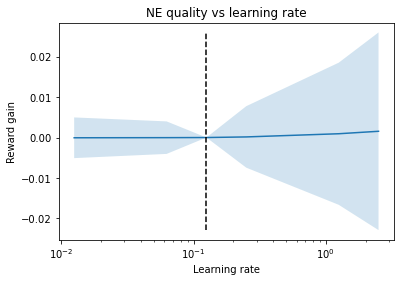

In [79]:
nash_quality_rel_vs_lr(lr_l[:],r_lr[:],2,mode='mean',figname="Rgain_vs_lr")

In [19]:
g = game_definition.StageGame(n,na,coupling_w=1,seed=game_seed,device="cuda",aligned=True,separable_type="additive")

In [20]:
game_seed = 4
init_seed = 0
n_players = 12
n_actions = 2
n_init_pol = 1000
w_l = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0]

In [21]:
end_pola_l =[]
ra_l = []
#note: the initial policies will be the same as the same seed is used for all game
for w in w_l:
    init_pol,end_pol,r = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=game_seed,init_seed=init_seed,separable_type="additive")
    end_pola_l.append(end_pol)
    ra_l.append(r)


In [31]:
end_polm_l =[]
rm_l = []
#note: the initial policies will be the same as the same seed is used for all game
for w in w_l:
    init_pol,end_pol,r = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=game_seed,init_seed=init_seed,separable_type="multiplicative",return_greedy=True,lr=10000)
    end_polm_l.append(end_pol)
    rm_l.append(r)

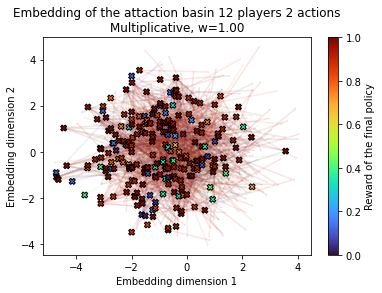

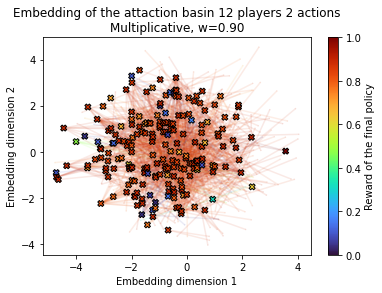

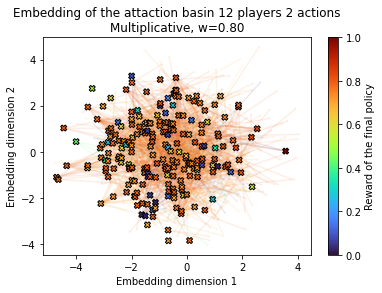

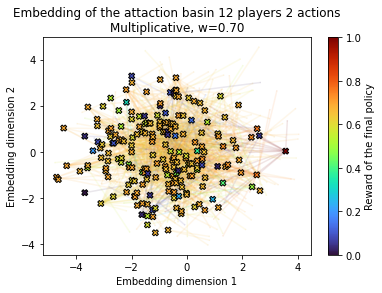

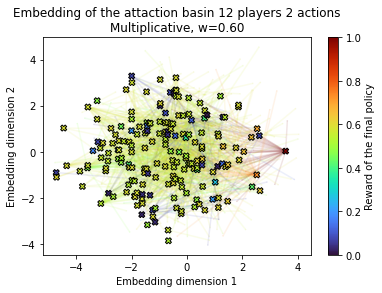

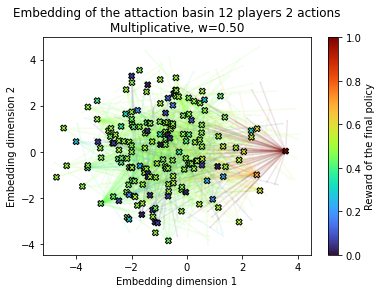

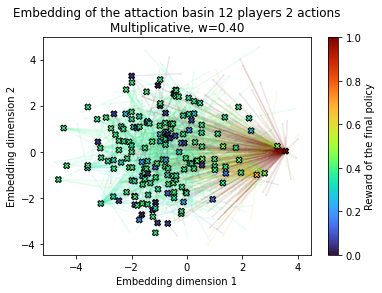

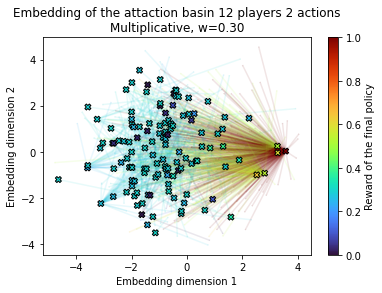

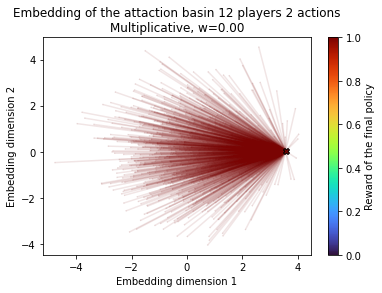

In [32]:
#use the same embedding for all the results:
X = np.tile(init_pol.reshape(init_pol.shape[0],-1),(len(w_l),1))
Y = np.vstack([elem.reshape(elem.shape[0],-1) for elem in end_polm_l])
emb = PLSSVD().fit(X,Y)
for i in range(len(w_l)):
    emb=plot_attraction(init_pol,end_polm_l[i],rm_l[i],
                        title=f"Embedding of the attaction basin {n_players} players {n_actions} actions\nMultiplicative, w={w_l[i]:.2f}",
                        embedding=emb,
                       )#figname=f"attaction_multiplicative_{n_players}_p_{n_actions}_a_w_{w_l[i]:.2f}")

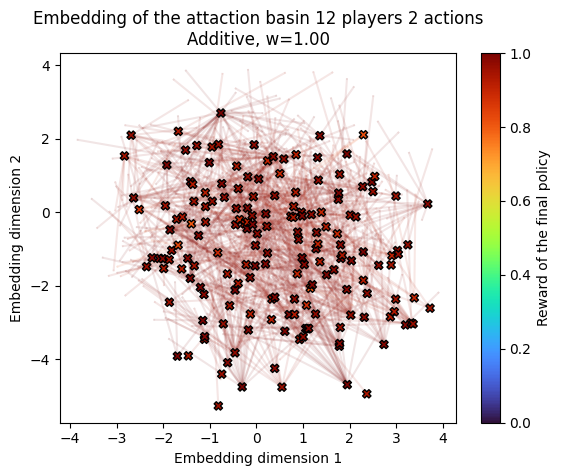

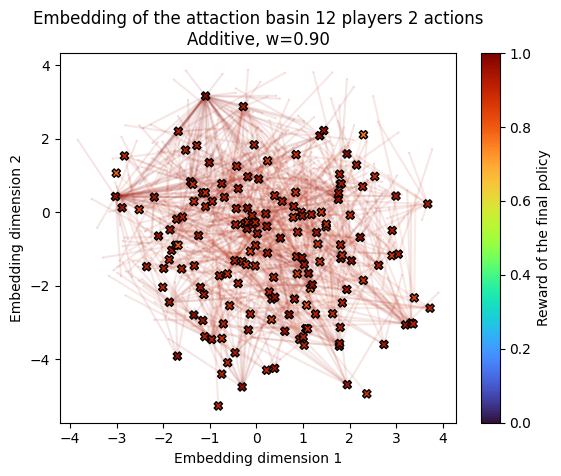

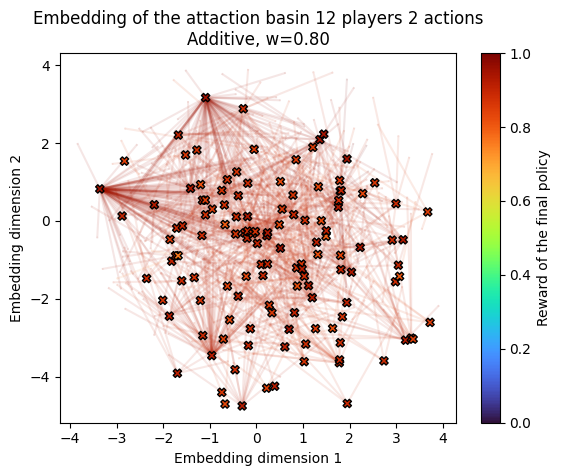

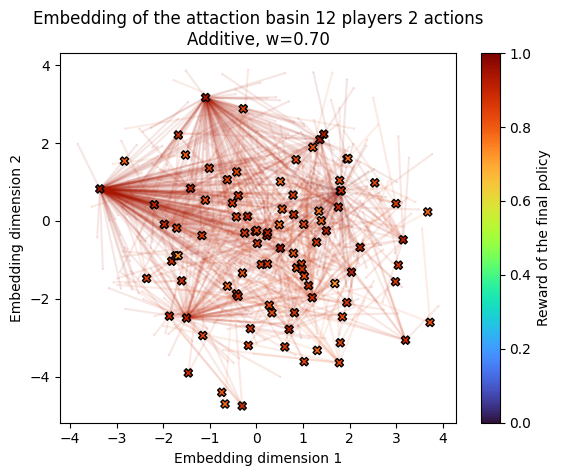

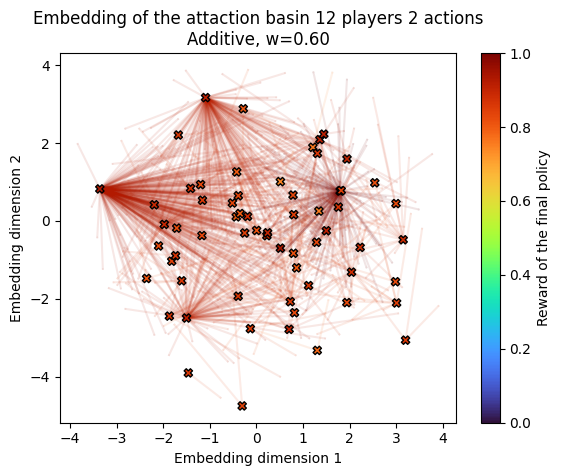

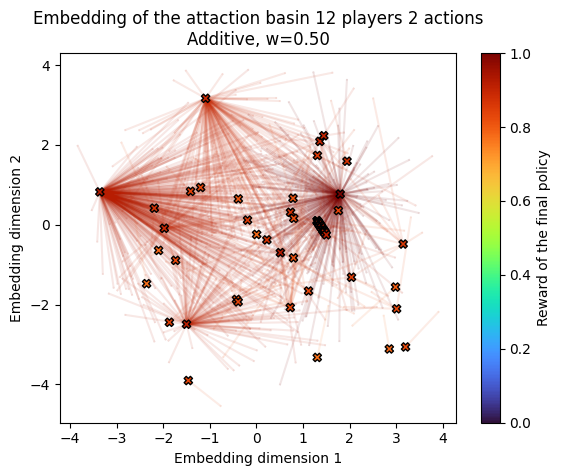

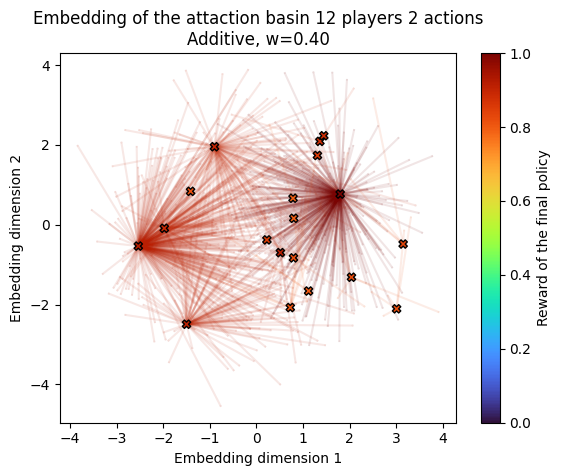

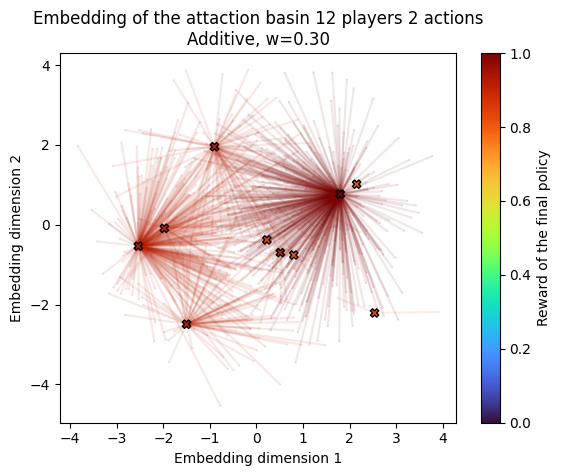

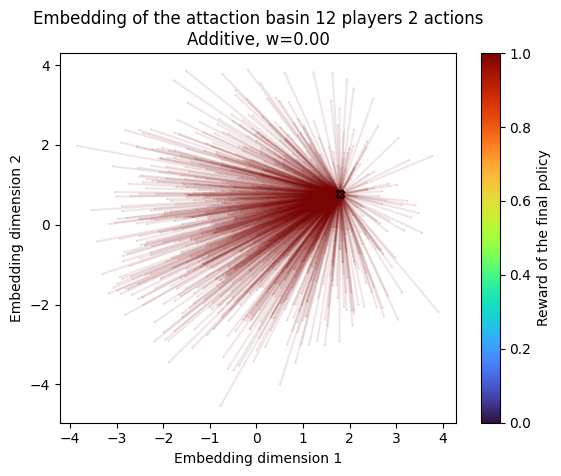

In [22]:
#use the same embedding for all the results:
X = np.tile(init_pol.reshape(init_pol.shape[0],-1),(len(w_l),1))
Y = np.vstack([elem.reshape(elem.shape[0],-1) for elem in end_pola_l])
from sklearn.decomposition import IncrementalPCA,KernelPCA
emb = PLSSVD().fit(X,Y)
#emb = KernelPCA(2).fit(np.vstack([X,Y]))
for i in range(len(w_l)):
    emb=plot_attraction(init_pol,end_pola_l[i],ra_l[i],
                        title=f"Embedding of the attaction basin {n_players} players {n_actions} actions\nAdditive, w={w_l[i]:.2f}",
                        embedding=emb,
                        figname=f"attaction_additive_{n_players}_p_{n_actions}_a_w_{w_l[i]:.2f}")

In [73]:
def nash_quality_vs_w(w_l,r_l,mode='mean',figname=None,title="NE quality vs action dominance"):

    fig,ax = plt.subplots()
    if mode=='mean':
        mean = np.mean(np.stack(r_l),axis=1)
        var = np.std(np.stack(r_l),axis=1)
        ax.plot(w_l,mean)
        ax.fill_between(w_l,mean-var,mean+var,alpha = 0.2)
    if mode=='median':
        median = np.median(np.stack(r_l),axis=1)
        q25 = np.percentile(np.stack(r_l),25,axis=1)
        q75 = np.percentile(np.stack(r_l),75,axis=1)
        ax.plot(w_l,median)
        ax.fill_between(w_l,q25,q75,alpha = 0.2)
    ax.set_xlabel("Coupling proportion")
    ax.set_ylabel("Reward")
    ax.set_ylim([0,1.01])
    ax.set_title(title)
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()
def nash_quality_vs_nplayers(n_l,r_l,mode='mean',figname=None):
    fig,ax = plt.subplots()
    if mode=='mean':
        mean = np.mean(np.stack(r_l),axis=1)
        var = np.std(np.stack(r_l),axis=1)
        ax.plot(n_l,mean,c=plt.cm.tab10(2))
        ax.fill_between(n_l,mean-var,mean+var,alpha = 0.2,color=plt.cm.tab10(2))
    if mode=='median':
        median = np.median(np.stack(r_l),axis=1)
        q25 = np.percentile(np.stack(r_l),25,axis=1)
        q75 = np.percentile(np.stack(r_l),75,axis=1)
        ax.plot(n_l,median,c=plt.cm.tab10(2))
        ax.fill_between(n_l,q25,q75,alpha = 0.2,color=plt.cm.tab10(2))
    ax.set_xlabel("Number of players")
    ax.set_ylabel("Reward")
    ax.set_ylim([0,1.01])
    ax.set_title("NE quality vs Number of players")
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()

In [24]:
n_init_pol = 2000
n_players = 10
n_actions=2
init_seed = 0
w_2 = np.linspace(0,1,11)
game_seeds = np.arange(3)

In [26]:
rm_t = []
for w in w_2:
    print(f"currently processing {w=:.2f}  ",end="\r")
    r = []
    for seed in game_seeds:
        _,_,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=int(seed),init_seed=init_seed,separable_type="multiplicative")
        r.append(r_s)
    rm_t.append(np.concatenate(r))

In [27]:
ra_t = []
for w in w_2:
    print(f"currently processing {w=}  ",end="\r")
    r = []
    for seed in game_seeds:
        _,_,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=int(seed),init_seed=init_seed,separable_type="additive")
        r.append(r_s)
    ra_t.append(np.concatenate(r))

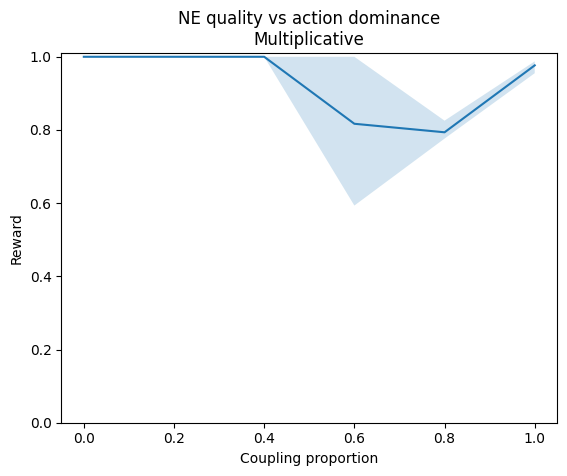

In [30]:
nash_quality_vs_w(w_2,rm_t,mode='median',title="NE quality vs action dominance\nMultiplicative",figname=f"ne_vs_w_{n_players}p_{n_actions}a_mult")

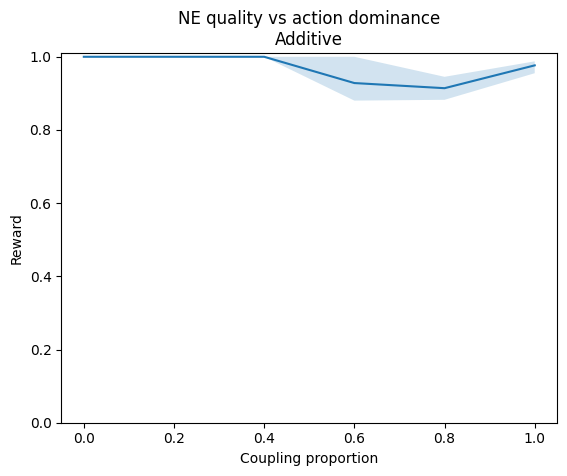

In [31]:
nash_quality_vs_w(w_2,ra_t,mode='median',title="NE quality vs action dominance\nAdditive",figname=f"ne_vs_w_{n_players}p_{n_actions}a_add")

In [40]:
n_init_pol = 500
n_players_l = np.arange(1,13)
n_actions = 2
init_seed = 0
w = 1
game_seeds = np.arange(20)
r_p = []
for n_players in n_players_l:
    r = []
    print(f"currently processing {n_players=}  ",end="\r")
    for seed in game_seeds:
        _,_,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=int(seed),init_seed=init_seed)
        r.append(r_s)
    r_p.append(np.concatenate(r))

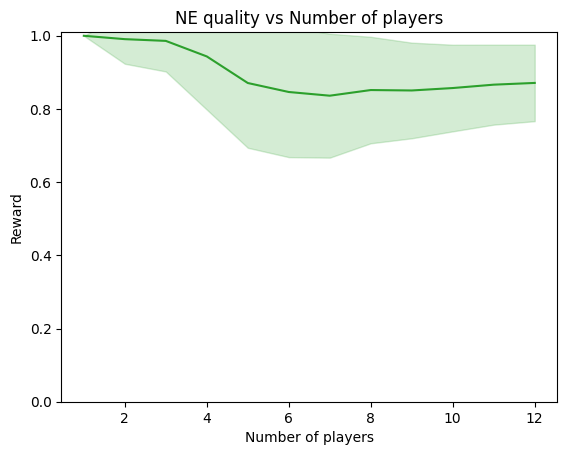

In [41]:
nash_quality_vs_nplayers(n_players_l,r_p,mode='mean')

In [ ]:

n_init_pol = 500
n_players = 6
n_actions_l = np.arange(2,5)
init_seed = 0
w = 1
game_seeds = np.arange(20)
r_a = []
for n_actions in n_actions_l:
    r = []
    for seed in game_seeds:
        _,_,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,mult_w=w,game_seed=int(seed),init_seed=init_seed)
        r.append(r_s)
    r_a.append(np.concatenate(r))

In [ ]:
'Actions per player'
'Number of actions profiles'
'Number of independent actions profiles'
nash_quality_vs_nactions(n_actions_l[:7],[n_players],r_a,mode='median',x_axis='Actions per player')

In [56]:
n_init_pol = 100
game_seeds = np.arange(10)
n_players_ar = np.arange(2,11,2)
n_points=2
nprofilemax=60000
n_actions_ar = np.stack([np.linspace(2,np.power(nprofilemax,1/p),n_points).astype(int) for p in n_players_ar])
init_seed = 0
w = 0.8
sep_type = "multiplicative"


r_ap = np.zeros((n_points,len(n_players_ar),n_init_pol*len(game_seeds)))
for ip,n_players in enumerate(n_players_ar):
    print(f"Player: {ip}/{len(n_players_ar)}       ")
    for ia,n_actions in enumerate(n_actions_ar[ip]):
        print(f"n actions: {ia}/{n_actions_ar.shape[1]}",end="\r")
        for idxs,seed in enumerate(game_seeds):
            _,_,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=int(seed),init_seed=init_seed,separable_type=sep_type)
            r_ap[ia,ip,idxs*n_init_pol:(idxs+1)*n_init_pol]=r_s

Player: 0/11       
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\grvallat\Documents\GitHub\RoboticConstruction\Simulator\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\grvallat\AppData\Local\Temp\ipykernel_26272\2212672239.py", line 17, in <module>
    _,_,r_s = get_ND_stage_game(n_players,n_actions,n_init_pol,coupling_w=w,game_seed=int(seed),init_seed=init_seed,separable_type=sep_type)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\grvallat\AppData\Local\Temp\ipykernel_26272\901488609.py", line 7, in get_ND_stage_game
    end_pol = IPGA_stage_game(game,init_pol=init_pols,iter=100000,lr=lr)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\grvallat\Documents\GitHub\OML-miniproject\algorithms.py", line 25, in IPGA_stage_game
    pol.data=project_

In [50]:
#r_apv1 = r_ap

In [36]:
def nash_quality_vs_nactions(na_ar,np_ar,r_ar,mode='mean', x_axis='Actions per player',figname=None):
    """r_ar: np.array(len(na_ar),len(np_ar),samples)
    """
    
    fig,ax = plt.subplots()
    if x_axis == 'Actions per player':
        x = n_actions_ar.T
    elif x_axis == 'Number of actions profiles':
        x = np.power(na_ar.T,np_ar.reshape((1,-1)))
        ax.set_xscale('log')
    elif x_axis == 'Number of independent actions profiles':
        x = na_ar.T*np_ar.reshape((1,-1))
        
    else:
        assert False, f"x_axis {x_axis} not implemented"
    if mode=='mean':
        mean = np.mean(r_ar,axis=-1)
        var = np.std(r_ar,axis=-1)
        ax.plot(x,mean,label=[f"{i} players" for i in np_ar])
        for i in range(len(np_ar)):
            ax.fill_between(x[:,i],mean[:,i]-var[:,i],mean[:,i]+var[:,i],alpha = 0.2,color=plt.cm.tab10(i))
    if mode=='median':
        median = np.median(r_ar,axis=-1)
        q25 = np.percentile(r_ar,25,axis=-1)
        q75 = np.percentile(r_ar,75,axis=-1)
        ax.plot(x,median,label=[f"{i} players" for i in np_ar])
        for i in range(len(np_ar)):
            ax.fill_between(x[:,i],q25[:,i],q75[:,i],alpha = 0.2,color=plt.cm.tab10(i))
    
    ax.legend()
    ax.set_xlabel(x_axis)
    ax.set_ylabel("Reward")
    #ax.set_ylim([0,1.01])
    ax.set_title("NE quality vs number of actions")
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()


In [58]:
n_players_ar = np.arange(2,6)
n_points=4
nprofilemax=5000
n_actions_ar = np.stack([np.linspace(2,np.power(nprofilemax,1/p),n_points).astype(int) for p in n_players_ar])

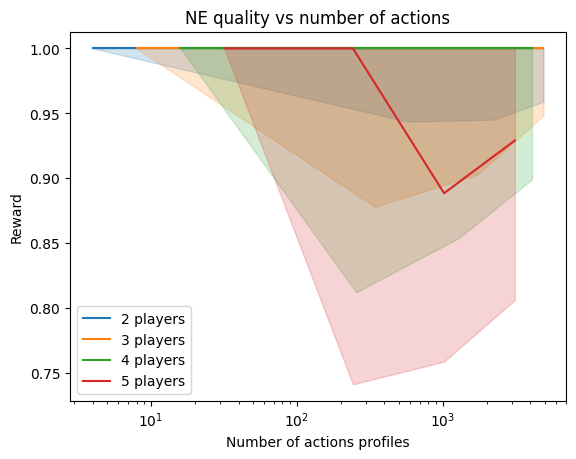

In [62]:
nash_quality_vs_nactions(n_actions_ar,n_players_ar,r_apv1,mode='median', x_axis='Number of actions profiles',figname="ne_vs_nactionsv3")

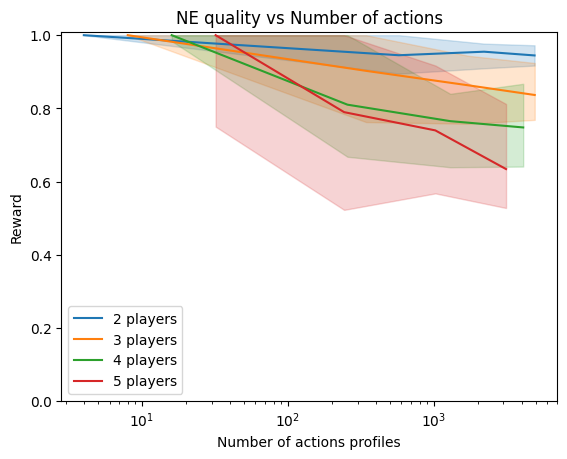

In [280]:
'Actions per player'
'Number of actions profiles'
'Number of independent actions profiles'
nash_quality_vs_nactions(n_actions_ar,n_players_ar,r_ap,mode='median', x_axis='Number of actions profiles')

In [48]:
def AIC_vs_nactions(na_ar,np_ar,r_ar,mode='mean', x_axis='Actions per player',figname=None):
    """r_ar: np.array(len(na_ar),len(np_ar),samples)
    """
    k = na_ar.T*np_ar.reshape((1,-1))
    AIC = np.expand_dims(2*k,-1) - 2*np.log(r_ar)
    fig,ax = plt.subplots()
    if x_axis == 'Actions per player':
        x = n_actions_ar.T
    elif x_axis == 'Number of actions profiles':
        x = np.power(na_ar.T,np_ar.reshape((1,-1)))
        ax.set_xscale('log')
    elif x_axis == 'Number of independent actions profiles':
        x = na_ar.T*np_ar.reshape((1,-1))
        
    else:
        assert False, f"x_axis {x_axis} not implemented"
    if mode=='mean':
        mean = np.mean(AIC,axis=-1)
        var = np.std(AIC,axis=-1)
        ax.plot(x,mean,label=[f"{i} players" for i in np_ar])
        for i in range(len(np_ar)):
            ax.fill_between(x[:,i],mean[:,i]-var[:,i],mean[:,i]+var[:,i],alpha = 0.2,color=plt.cm.tab10(i))
    if mode=='median':
        median = np.median(AIC,axis=-1)
        q25 = np.percentile(AIC,25,axis=-1)
        q75 = np.percentile(AIC,75,axis=-1)
        ax.plot(x,median,label=[f"{i} players" for i in np_ar])
        for i in range(len(np_ar)):
            ax.fill_between(x[:,i],q25[:,i],q75[:,i],alpha = 0.2,color=plt.cm.tab10(i))
    
    ax.legend()
    ax.set_xlabel(x_axis)
    ax.set_ylabel("AIC")
    ax.set_title("AIC vs number of actions")
    if figname is not None:
        plt.savefig("Figures/"+figname+".pdf")
    plt.show()

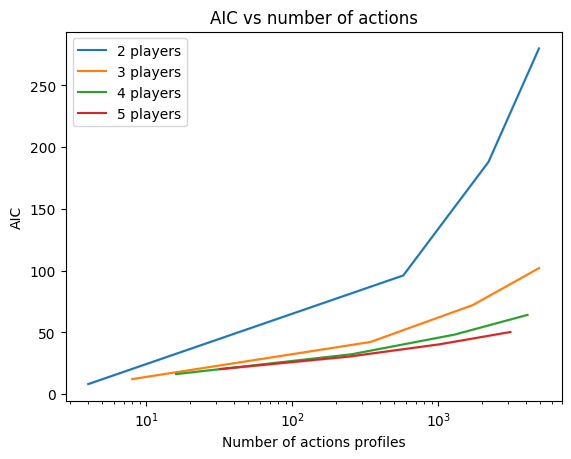

In [49]:
AIC_vs_nactions(n_actions_ar,n_players_ar,r_ap,mode='mean', x_axis='Number of actions profiles',figname="AIC_vs_nactions")

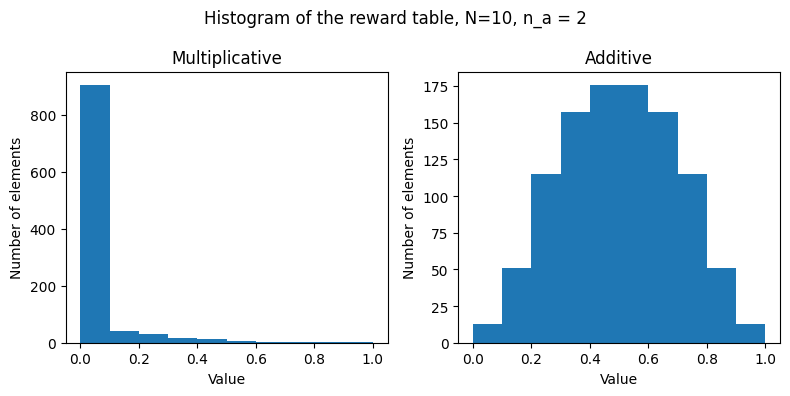

In [117]:
from scipy.stats import beta
n_players=10
n_actions = 2
w = 0
seed = 2

fig,axs = plt.subplots(1,2,figsize = (8,4))
x=np.linspace(0,10,100)



separable_type="multiplicative"

game = game_definition.StageGame(n_players,n_actions,coupling_w=w,seed=seed,device="cuda",aligned=True,separable_type=separable_type)

fig.suptitle(f"Histogram of the reward table, N={n_players}, n_a = {n_actions}")
axs[0].hist(game.r.flatten().cpu().numpy(),10)
axs[0].set_title("Multiplicative")
axs[0].set_ylabel("Number of elements")
axs[0].set_xlabel("Value")

separable_type="additive"
game = game_definition.StageGame(n_players,n_actions,coupling_w=w,seed=seed,device="cuda",aligned=True,separable_type=separable_type)
val,bins,_ = axs[1].hist(game.r.flatten().cpu().numpy(),10)
axs[1].set_title("Additive")
axs[1].set_ylabel("Number of elements")
axs[1].set_xlabel("Value")
plt.tight_layout()
plt.savefig("figures/distrib_R.pdf")

In [92]:
sum([np.power(-1,i)*binom(n,i)*np.power(np.clip((x-i),0,n),n) for i in range(n+1)])/np.prod(np.arange(1,n+1))

array([0.00000000e+00, 3.04708817e-17, 3.12021829e-14, 1.79927509e-12,
       3.19510353e-11, 2.97567204e-10, 1.84245770e-09, 8.60726990e-09,
       3.27178601e-08, 1.06245395e-07, 3.04708817e-07, 7.90336196e-07,
       1.88667617e-06, 4.20064482e-06, 8.81343537e-06, 1.75674185e-05,
       3.34813526e-05, 6.13299215e-05, 1.08424830e-04, 1.85632409e-04,
       3.08655948e-04, 4.99598714e-04, 7.88804984e-04, 1.21695032e-03,
       1.83731895e-03, 2.71816732e-03, 3.94503179e-03, 5.62280013e-03,
       7.87733299e-03, 1.08563991e-02, 1.47296790e-02, 1.96876001e-02,
       2.59387985e-02, 3.37060577e-02, 4.32206570e-02, 5.47151687e-02,
       6.84148606e-02, 8.45279842e-02, 1.03235346e-01, 1.24679671e-01,
       1.48955331e-01, 1.76099091e-01, 2.06082499e-01, 2.38806522e-01,
       2.74098935e-01, 3.11714821e-01, 3.51340355e-01, 3.92599867e-01,
       4.35065943e-01, 4.78272162e-01, 5.21727838e-01, 5.64934057e-01,
       6.07400133e-01, 6.48659645e-01, 6.88285179e-01, 7.25901065e-01,
      

In [49]:
x=1
[(np.power(-1,i))*binom(n,i)*np.power(np.clip((x-i),0,n),n-1) for i in range(n+1)]

[1.0, -0.0, 0.0]

In [ ]:
(-1**i)